In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm_notebook as tqdm

In [19]:
FACE_ATTR = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
    'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
    'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
    'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
    'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
    'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
]

SPOOF_TYPE = ['Live',                               # 0     - live
    'Photo', 'Poster', 'A4',                        # 1,2,3 - PRINT 
    'Face Mask', 'Upper Body Mask', 'Region Mask',  # 4,5,6 - PAPER CUT 
    'PC', 'Pad', 'Phone',                           # 7,8,9 - REPLAY 
    '3D Mask'                                       # 10    - 3D MASK 
]

ILLUMINATION = ['Live', 'Normal', 'Strong', 'Back', 'Dark']

ENVIRONMENT = ['Live', 'Indoor', 'Outdoor']

LOCAL_ROOT = 'CelebA_Spoof/'

# Spoof атаки, которые оставляем
spoof_filter = [0, 1, 2, 3, 7, 8, 9]

## Data Preparation

In [ ]:
import cv2
import os
import logging
import pandas as pd
from tqdm import tqdm_notebook as tqdm

def read_image(image_path, bbox_inc = 0.3):
    """
    Read an image from input path
    
    params:
        - `image_path` : str - the path of image.
        - `bbox_inc` : float - image bbox increasing
    return:
        - `image`: Required image.
    """

    image_path = LOCAL_ROOT + image_path

    img = cv2.imread(image_path)
    # Get the shape of input image
    real_h, real_w = img.shape[:2]
    assert os.path.exists(image_path[:-4] + '_BB.txt'),'path not exists' + ' ' + image_path
    
    with open(image_path[:-4] + '_BB.txt','r') as f:
        material = f.readline()
        try:
            x, y, w, h = material.strip().split(' ')[:-1]
        except:
            logging.info('Bounding Box of' + ' ' + image_path + ' ' + 'is wrong')   

        try:
            w = int( int(float(w))*(real_w / 224) )
            h = int( int(float(h))*(real_h / 224) )
            x = int( int(float(x))*(real_w / 224) - bbox_inc/2*w )
            y = int( int(float(y))*(real_h / 224) - bbox_inc/2*h )
            # Crop face based on its bounding box
            x1 = 0 if x < 0 else x 
            y1 = 0 if y < 0 else y
            x2 = real_w if x1 + (1+bbox_inc)*w > real_w else int(x + (1+bbox_inc)*w)
            y2 = real_h if y1 + (1+bbox_inc)*h > real_h else int(y + (1+bbox_inc)*h)
            img = img[y1:y2,x1:x2,:]

        except:
            logging.info('Cropping Bounding Box of' + ' ' + image_path + ' ' + 'goes wrong')   

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def save_image(image_path, img, size, scaleup = True):
    """
    Read an image from input path
    
    params:
        - `img`: cv image
        - `image_path` : str - the path of image to save.
        - `size` : int - the size of the largest side of the shape 
    """

    image_path = LOCAL_ROOT + image_path

    # Get the shape of input image
    h, w = img.shape[:2]
    
    ratio = size/max(h,w)
    if not scaleup:
        ratio = min(ratio, 1.)
        
    if ratio != 1.0:
        new_shape = int(w*ratio+0.01), int(h*ratio+0.01)
        img = cv2.resize(img, new_shape)
    
    return cv2.imwrite(image_path, img)


def process_images(labels, size, scaleup=True):
    for img_path in tqdm(labels):
        img = read_image(img_path)

        new_img_path = img_path.replace('Data', 'data'+str(size))
        new_img_dir = os.path.dirname(new_img_path)

        if not os.path.exists(new_img_dir):
            os.makedirs(new_img_dir)
        save_image(new_img_path, img, size, scaleup=scaleup)

((494405, 44), (67170, 44))

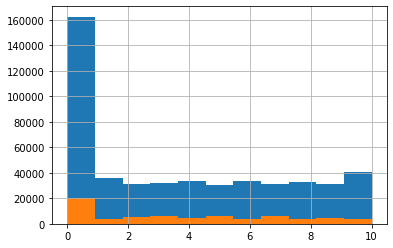

In [9]:
dir = LOCAL_ROOT + 'metas/intra_test/'

train_label = pd.read_json(
    dir+'train_label.json', orient='index'
).apply(pd.to_numeric, downcast='integer')

test_label = pd.read_json(
    dir+'test_label.json', orient='index'
).apply(pd.to_numeric, downcast='integer')

train_label[40].hist(bins=11)
test_label[40].hist(bins=11)

train_label.shape, test_label.shape

In [10]:
labels_txt = pd.read_csv(dir+'test_label.txt', sep=' ', header=None, index_col=0)[1].astype('int32')
labels_txt.index.name = None
labels_txt.name = None

labels_df = (test_label[40] != 0).astype('int32')
labels_df.name = None

print(labels_txt.equals(labels_df))

del labels_txt, labels_df

True


(356690, 44) (49646, 44)


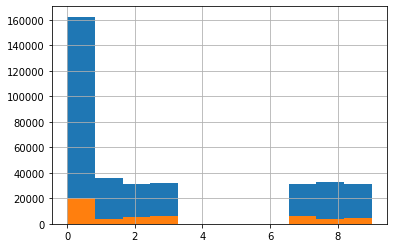

In [17]:
tmp_train_label = train_label[train_label[40].isin(spoof_filter)]
tmp_test_label = test_label[test_label[40].isin(spoof_filter)]
tmp_train_label[40].hist(bins=11)
tmp_test_label[40].hist(bins=11)

print(tmp_train_label.shape, tmp_test_label.shape)

tmp_train_label.index = tmp_train_label.index.str.replace('Data/', '')
tmp_test_label.index = tmp_test_label.index.str.replace('Data/', '')

# tmp_test_label.to_csv('data128/test_label.csv')
# tmp_test_label.to_csv('data256/test_label.csv')
# tmp_train_label.to_csv('data128/train_label.csv')
# tmp_train_label.to_csv('data256/train_label.csv')

pd.concat([tmp_train_label, tmp_test_label]).to_csv('data128/label.csv')
pd.concat([tmp_train_label, tmp_test_label]).to_csv('data256/label.csv')

del tmp_train_label, tmp_test_label

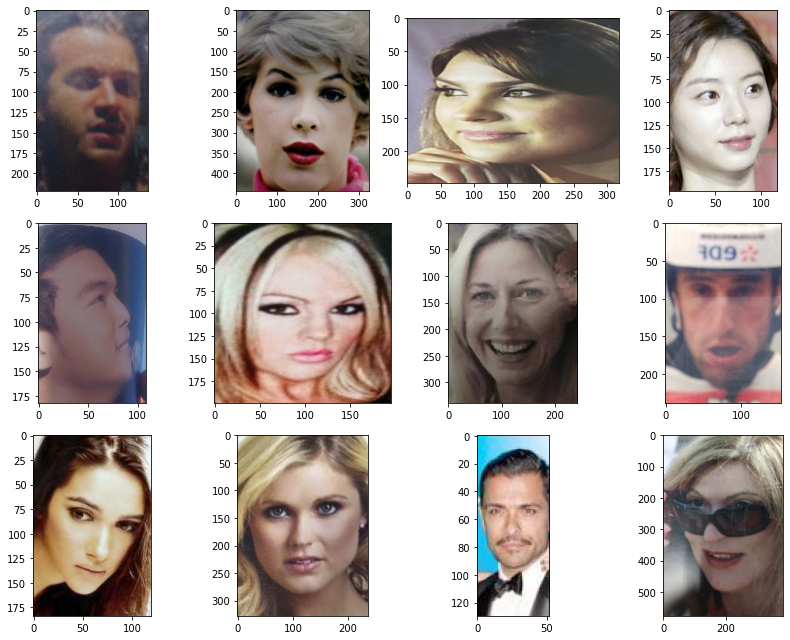

In [6]:
fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    img = read_image(test_label.index[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
plt.show()

In [7]:
process_images(train_label.index, 128)
process_images(test_label.index, 128)
process_images(train_label.index, 256, scaleup=False)
process_images(test_label.index, 256, scaleup=False)

  0%|          | 0/356690 [00:00<?, ?it/s]

  0%|          | 0/49646 [00:00<?, ?it/s]

  0%|          | 0/356690 [00:00<?, ?it/s]

  0%|          | 0/49646 [00:00<?, ?it/s]

## Training

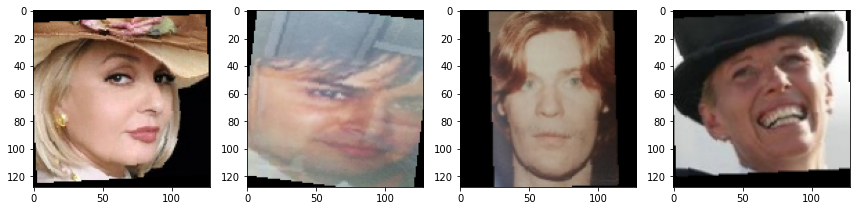

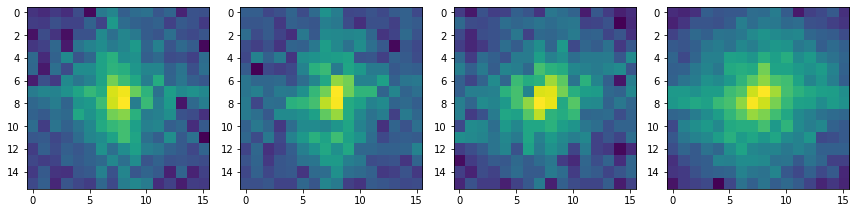

tensor([0, 9, 3, 0])

In [3]:
import torchvision.transforms as T

from matplotlib import pyplot as plt
from src.dataset_loader import get_train_loader
from src.config import get_default_config, update_config

conf = get_default_config()

conf.train.batch_size = 4

conf.dataset.spoof_categories = 0

loader = get_train_loader(conf)

data_iter = iter(loader)
sample, ft_sample, target = data_iter.next()

fig = plt.figure(figsize=(12,4))
for i in range(conf.train.batch_size):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(T.ToPILImage()(sample[i]))
    plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,4))
for i in range(conf.train.batch_size):
    fig.add_subplot(1, 4, i+1)
    plt.imshow(T.ToPILImage()(ft_sample[i]))
    plt.tight_layout()
plt.show()

target

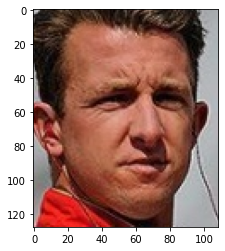

In [3]:
from PIL import Image

img = Image.open('CelebA_Spoof_crop/data128/train/1/live/000184.jpg')

plt.imshow(img)

In [7]:
spoof_labels = [[0], [1,2,3,7,8,9]]

In [6]:
f = lambda x : (x*x)

f(2)

4

In [16]:
s = 3
next(i for i, l in enumerate(spoof_labels) if s in l)

1

In [10]:
s = 1
[(i, spoof_labels.index(s)) for i, label in enumerate(spoof_labels) if s in label]

ValueError: 1 is not in list